In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator
import pickle 

In [12]:
VQE_training =True
n_qubits=4
j_coupling=0.5
g_coupling=1.5
n_rep_VQEansatz=1

def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x,label='ground state energy')
    #plt.show()


In [3]:
def getGoundState(n_qubits=n_qubits,j_coupling=j_coupling,g_coupling=g_coupling,n_rep_VQEansatz=1,nSteps=200
                 ,learning_rate=1e-1):
    h_coupling=j_coupling*g
    qr_VQE = QuantumRegister(n_qubits)
    qc_VQE = QuantumCircuit(qr_VQE)
    ansatz_VQE =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz)
    qc_VQE.h(qr_VQE)
    qc_VQE.compose(ansatz_VQE, inplace=True)  
    
    observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])
    for i in np.arange(1,n_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
    for i in range(n_qubits-1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))
        
       
    qnn_VQE=EstimatorQNN(
        estimator=Estimator(options={"shots":1e10}),
        circuit=qc_VQE,
        weight_params=ansatz_VQE.parameters,
        observables=observable
        )

    eigenValues=np.linalg.eig(observable.to_matrix())[0]
    eigenValues.sort()

    groundEnergy=eigenValues[0]
    #print("ground state energy =", groundEnergy)
    
    init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi
    weights=init_weights
    
    loss=[]
    for i in range(nSteps):
        vev=qnn_VQE.forward([], weights)[0][0]
        input_grad, weight_grad=qnn_VQE.backward([],weights)
        grad=weight_grad[0,0,:]
        weights=weights-learning_rate*grad
        loss.append(vev)

#         if i%1==0:

#             clear_output(wait=True)
#             plt.figure(1)
#             callback_graph(loss)
#             plt.plot(range(len(loss)),groundEnergy*np.ones(len(loss)),label='truth')
#             plt.legend()
#             #plt.yscale('log')
#             plt.show()

    return weights,vev,groundEnergy

Next, prepare a series of ground states and its labels based on the value of |g|

For |g|<1, two-fold degenerate ground state.

For |g|>1, non-degenerate ground state.

In [14]:
if VQE_training:#Obtaining ground state for |g|<1 
    nSteps=50
    lowGs=np.arange(0,1.0,0.05)
    highGs=np.arange(1.05,2.05,0.05)
    w_low=[]
    Egs_estimate_low=[]
    Egs_low=[]
    for g in lowGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e0)
            diff=abs(Egs_estimate-Egs)/abs(Egs)

            if diff< 0.015:
                break
                
        print("g = ",g," diff=",diff)
                
        w_low.append(weights)
        Egs_estimate_low.append(Egs_estimate)
        Egs_low.append(Egs)

    print("lowG finished")
    dict_low={"weights": w_low,"E_gs_estimate": Egs_estimate_low,
              "E_gs":Egs_low,"g":lowGs}
    with open('lowG_dict.pkl', 'wb') as f:
        pickle.dump(dict_low, f)


    w_high=[]
    Egs_estimate_high=[]
    Egs_high=[]
    for g in highGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps)
            diff=abs(Egs_estimate-Egs)/abs(Egs)
            if diff< 0.015:
                break
        print("g = ",g," diff=",diff)
        w_high.append(weights)
        Egs_estimate_high.append(Egs_estimate)
        Egs_high.append(Egs)

    dict_high={"weights": w_high,"E_gs_estimate":Egs_estimate_high,
               "E_gs": Egs_high ,"g":highGs}
    with open('highG_dict.pkl', 'wb') as f:
        pickle.dump(dict_high, f)
        
    dataset={'weights':dict_low['weights']+dict_high['weights'], 
         'label': np.concatenate([-1*np.ones(len(dict_low['weights'])),np.ones(len(dict_high['weights']))])
        }
    
    with open('dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)
    

g =  0.0  diff= 0.00011113944297698926
g =  0.05  diff= 2.608591092216968e-06
g =  0.1  diff= 0.00013951963060539327
g =  0.15000000000000002  diff= 0.00018612002164138396
g =  0.2  diff= 0.0005032481277542712
g =  0.25  diff= 0.003945971971958352
g =  0.30000000000000004  diff= 0.0023471561814016333
g =  0.35000000000000003  diff= 0.013806930014074905
g =  0.4  diff= 0.007230256553881722
g =  0.45  diff= 0.010475624917370346
g =  0.5  diff= 0.01406851320958552
g =  0.55  diff= 0.017229280304161022
g =  0.6000000000000001  diff= 0.025921528162427175
g =  0.65  diff= 0.025384688844442515
g =  0.7000000000000001  diff= 0.029092262859574412
g =  0.75  diff= 0.01170238157830141
g =  0.8  diff= 0.009524958591846178
g =  0.8500000000000001  diff= 0.008272057898349611
g =  0.9  diff= 0.007206379793648562
g =  0.9500000000000001  diff= 0.009829539736580364
lowG finished
g =  1.05  diff= 0.04185241320613338
g =  1.1  diff= 0.00862821857630399
g =  1.1500000000000001  diff= 0.07441878538586763
g

In [15]:
# with open('lowG_dict.pkl', 'rb') as f:
#     dict_low = pickle.load(f)

# with open('highG_dict.pkl', 'rb') as f:
#     dict_high = pickle.load(f)

with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [16]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range(len(dataset['label'])):
    if i % 5 == 0:
        X_test.append(dataset['weights'][i])
        y_test.append(dataset['label'][i])
    
    else:
        X_train.append(dataset['weights'][i])
        y_train.append(dataset['label'][i])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [17]:
n_layers=1
n_params=n_layers*1+n_qubits+1
weights = ParameterVector("weight", n_params)
params_index=0
qr = QuantumRegister(n_qubits)
qc = QuantumCircuit(qr)
qc.compose(RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz), inplace=True) 
qc.barrier()
for layer in range(n_layers):
    for i in np.arange(0,n_qubits-1,1):
        qc.rzz(weights[params_index],i,i+1)
    params_index += 1
qc.barrier()
#pooling layer:
for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(weights[params_index],i*2)
    
params_index += 1

for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(weights[params_index],i*2+1)
    qc.cx(2*i,2*i+1)
params_index += 1

for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(-weights[params_index-2],i*2+1)
qc.barrier()

for i in np.arange(0,int(n_qubits/4),1):
    qc.rzz(weights[params_index],i*4+1,i*4+3)
qc.barrier()
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(weights[params_index],i*4+1)
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(weights[params_index],i*4+3)
    qc.cx(i*4+1,i*4+3)
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(-weights[params_index-2],i*4+3)
qc.barrier()

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


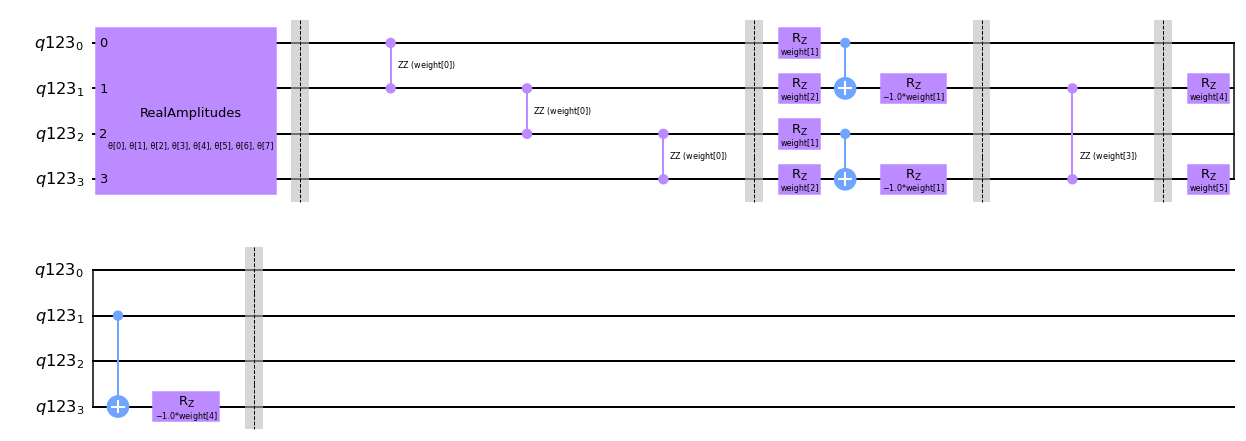

In [18]:
qc.draw('mpl')

In [19]:
qc.num_parameters

14

In [20]:
estimator = Estimator()
ob = SparsePauliOp.from_list([("I"*(n_qubits-1)+"Z" , 1 )])

In [21]:
n_VQEparams=len(X_train[0])
n_QCNNweights=qc.num_parameters-n_VQEparams

In [22]:
def getParamsVariations(x,weights):
    n_VQEparams=len(x)
    params=np.concatenate([x,weights])
    param_variation_list=[params]
    for i in range(len(weights)):

        tmp_param=params.copy()
        tmp_param[n_VQEparams+i]+=np.pi/2
        param_variation_list.append(tmp_param)
        tmp_param=params.copy()
        tmp_param[n_VQEparams+i]-=np.pi/2
        param_variation_list.append(tmp_param)
    return np.array(param_variation_list)

def getGrad(jobResult):
    vev=jobResult[0]
    grad=[]
    for i in range(int((jobResult.shape[0]-1)/2)):
        tmpGrad=(jobResult[2*i+1]-jobResult[2*i+2])/2
        grad.append(tmpGrad)
    grad=np.array(grad)
    return vev,grad

In [40]:
initial_weights=2*np.pi*np.random.rand(n_QCNNweights)
weights=initial_weights

In [42]:
nIterations=50
learning_rate=1e-1
loss_list=[]

for Iter in range(nIterations):
    params_list_all=[]
    for i in range(len(X_train)):
        params_list_all.append(getParamsVariations(X_train[i],weights))
    params_list_all=np.array(params_list_all)

    cost=0
    grad_all=np.zeros(n_QCNNweights)
    for i in range(len(X_train)):
        circuits=[qc]*len(params_list_all[i])
        observable=[ob]*len(params_list_all[i])
        param_variation_list=params_list_all[i]
        job=estimator.run(circuits=circuits, observables=observable
                          , parameter_values=param_variation_list)
        jobResult=job.result().values
        vev,circuitGrad=getGrad(jobResult)
        cost+=(vev-y_train[i])**2
        grad= 2*(vev-y_train[i])*circuitGrad
        grad_all+=grad
        
    print(cost)
    loss_list.append(cost)
    weights-=learning_rate*grad_all


35.99560997821228
34.65304099311866
33.03013174067383
30.605201895060077
30.569835860333754
30.560573362828926
30.542535096195508
30.53642579283674
30.52692944077001
30.52349857966403
30.519539567171957
30.52011386846297
30.523320541137103
30.534827835339026
30.558072954085855
30.605731313537245
30.699112206116162
30.848473451040235
31.14113063343719
31.37276136363386
31.82219920998339
31.547291227114037
31.473706011744525
31.027216819707384


KeyboardInterrupt: 

In [36]:
def predict(X,qc,ob,weights):

    prediction=[]
    for i in range(len(X_train)):
        job=estimator.run(circuits=qc, observables=ob
                          , parameter_values=np.concatenate([X_train[i],weights]))
        jobResult=job.result().values
        prediction.append(jobResult)
    return np.array(prediction).flatten()

In [37]:
predict(X_train,qc,ob,weights)

array([ 0.02002903, -0.32645514,  0.19752791, -0.33747842, -0.27682427,
       -0.23314331, -0.25365168, -0.25618693,  0.26789896,  0.08856663,
        0.2901709 , -0.24511787, -0.20840835, -0.23175148,  0.2347657 ,
        0.24124776,  0.23765907, -0.07223401,  0.05285635,  0.22348076,
        0.12712569,  0.24791548, -0.06147588,  0.23928209,  0.18270137,
       -0.29745334, -0.07869564, -0.04682561, -0.25588991, -0.07398561,
       -0.1868502 ,  0.2337994 ])

In [38]:
y_train

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])